# GradCAM
<b>~ Gradient-weighted Class Activation Mapping ~</b>

In [1]:
# Use VGG16 for sample.
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model

Using TensorFlow backend.


### Module role description

|         Name         |                             Role                             |
|:--------------------:|:------------------------------------------------------------:|
|        `VGG`         |            ImageNet で事前学習した VGG16 のモデル            |
|  `preprocess_input`  |         VGG16 が要求する形に画像を前処理してくれる。         |
| `decode_predictions` |         GG16 の予測結果をクラスラベルに対応させる。          |
|      `load_img`      |         画像をファイルから読み込み、PIL形式で返す。          |
|    `img_to_array`    |               PIL形式から ndarray に変換する。               |
|       `Model`        | `inputs` と `outputs` を与えるだけで簡単にモデルを作成する。 |

In [2]:
model = VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


***

In [3]:
! tree

.
├── GradCAM.ipynb
├── GradCAM.py
├── README.md
└── img
    ├── American_egret.png
    ├── GradCAM.png
    └── Heatmap.png

1 directory, 6 files


In [4]:
! python --version

Python 3.6.8 :: Anaconda, Inc.


***

In [5]:
from PIL import Image

In [6]:
img_path = "./img/American_egret.png"

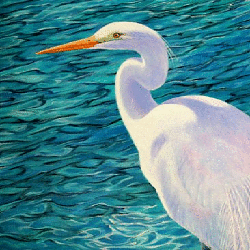

In [7]:
# sample image.
Image.open(img_path).resize((250,250))

***
***

## Visualize feature map.
First, I visualize mere feature maps.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width=60%>

In [9]:
# 各特徴マップを出力する新モデルを作成する(重みはそのまま)。
layers = model.layers[1:19] # 'block1_conv1' から 'block5_pool' まで
layer_outputs = [layer.output for layer in layers]
visualization_model = Model(inputs=model.input, outputs=layer_outputs)

In [10]:
def load_image(img_path):
    """
    関数の概要：VGG16のモデルに合うように画像を前処理して読み込む
    """
    img = load_img(img_path, target_size=(224, 224)) # PIL形式で画像を取得する。
    x = img_to_array(img)                            # ndarray の形式に整形する。
    x = np.expand_dims(x, axis=0)                    # 次元を追加する(batch_size の分)
    x = preprocess_input(x)                          # VGG16 が学習させた形に前処理を行う。
    return x

In [11]:
x = load_image(img_path) # VGG16 に適した形に前処理し、画像を渡す。

In [12]:
predictions = model.predict(x) # 普通のクラス予測。
top_1 = decode_predictions(predictions)[0][0]   # 最も高い確率で予測したクラスの情報。
print("class name : {}".format(top_1[1]))
print("WordNet ID : {}".format(top_1[0]))
print("Probability: {:.3f}".format(top_1[2]))

class name : American_egret
WordNet ID : n02009912
Probability: 0.978


In [13]:
outputs = visualization_model.predict(x)

In [14]:
# 特徴マップを全て出力している。
print(len(outputs) == len(layers))

True


【 block1_conv1 】


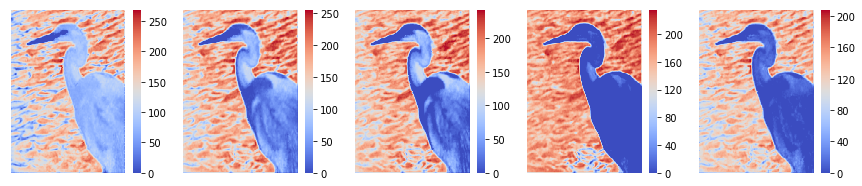

【 block1_conv2 】


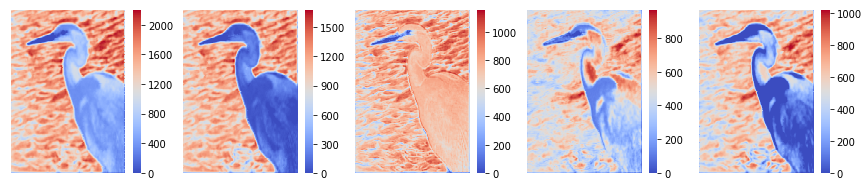

【 block1_pool 】


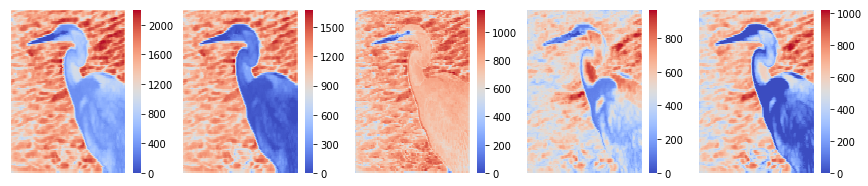

【 block2_conv1 】


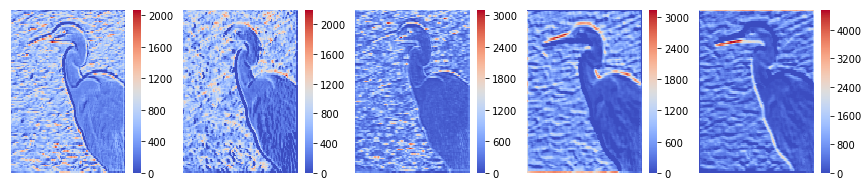

【 block2_conv2 】


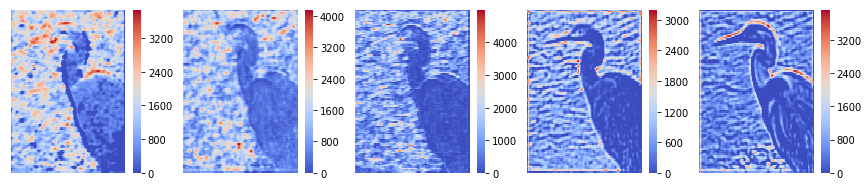

【 block2_pool 】


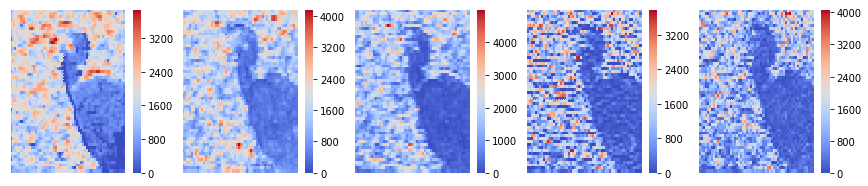

【 block3_conv1 】


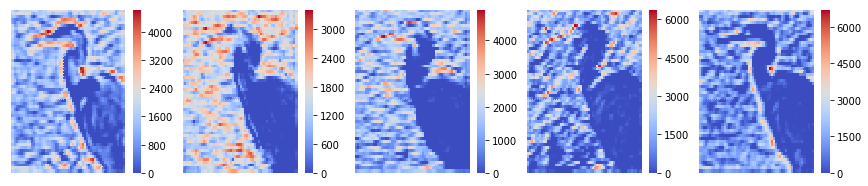

【 block3_conv2 】


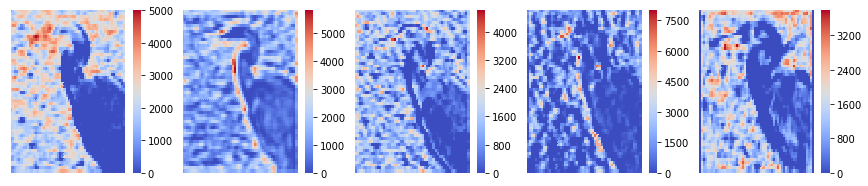

【 block3_conv3 】


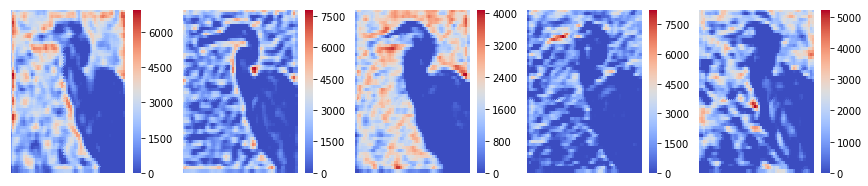

【 block3_pool 】


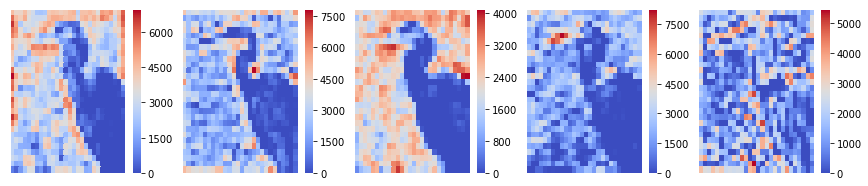

【 block4_conv1 】


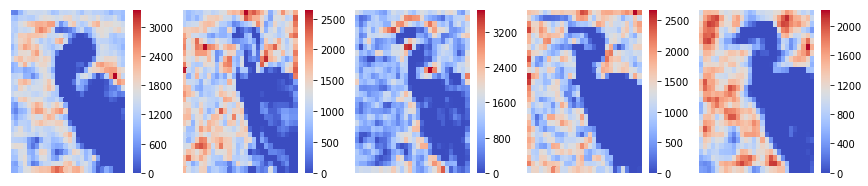

【 block4_conv2 】


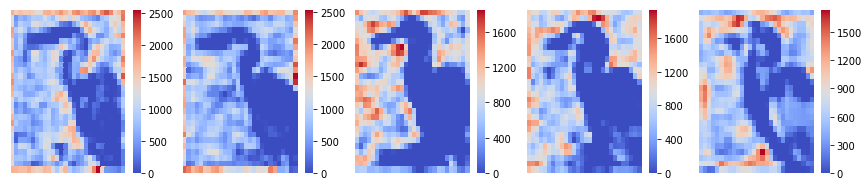

【 block4_conv3 】


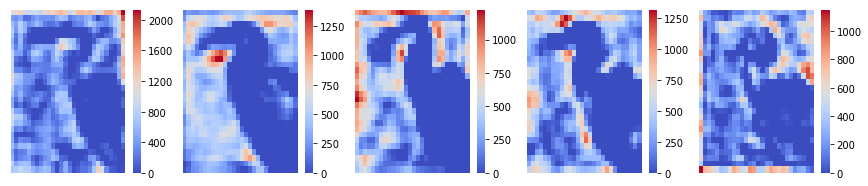

【 block4_pool 】


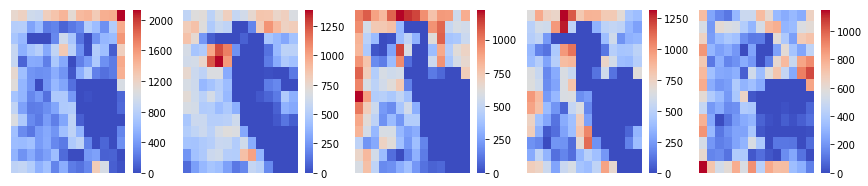

【 block5_conv1 】


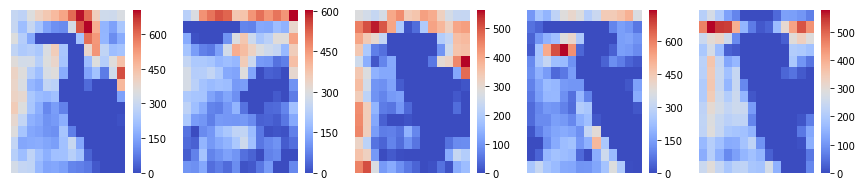

【 block5_conv2 】


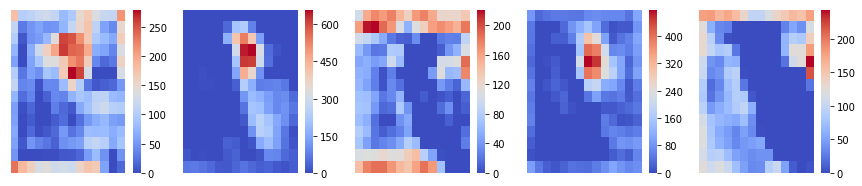

【 block5_conv3 】


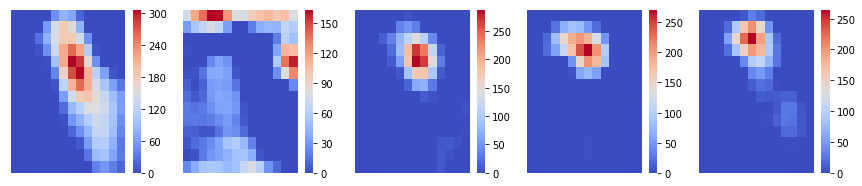

【 block5_pool 】


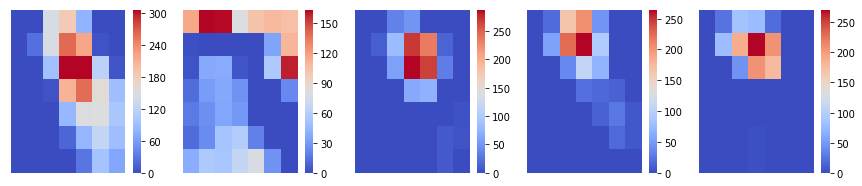

In [15]:
# 各層の特徴マップに関して、平均値の高い方から5つを出力する。

for feature_maps, layer in zip(outputs, layers):    
    print("【 {} 】".format(layer.name)) # 層の名前を出力
    
    Mean_Strength = [feature_maps[:,:,:,i].mean() for i in range(feature_maps.shape[-1])] 
    top_5_indexes = sorted(range(len(Mean_Strength)), key=lambda i: Mean_Strength[i], reverse=True)[:5]
    
    plt.figure(figsize=(18, 3))
    for i,index in enumerate(top_5_indexes):
        plt.subplot(1,6,i+1)
        sns.heatmap(feature_maps[0,:,:,index], xticklabels=False, yticklabels=False, cmap="coolwarm")
    
    plt.show()

***
***

***

## GradCAM

In [16]:
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import keras
import cv2

### Module role description

| Name               | Role                                         |
| ------------------ | -------------------------------------------- |
| Lambda             | Tensor での配列操作を楽にする。              |
| Sequential         | Tensor での配列操作を楽にする。              |
| ops                | 勾配の管理                                   |

<img src="http://gradcam.cloudcv.org/static/images/network.png" width=60%>

<div style="padding: 10px; margin-bottom: 10px; border: 1px dotted #333333;">
<div style="font-family: 'メイリオ';">
1. 「予測への影響が大きいピクセル」をヒートマップを利用して可視化したい。
2. 「ピクセル値に微小変化を加えたときに予測に生じる変化の大きさ」が、「予測への影響の大きさ」を表せるのでは？
3. 「CNNの層を増すごとに複雑な特徴量を捉えることができると考えられている」 & 「全結合層では空間的な情報が失われる」ことより、「最後の畳み込み層の出力結果(特徴量マップ)」を利用するのが良いのでは？？
><b>A number of previous works have asserted that deeper representations in a CNN capture higher-level visual constructure.</b> Furthermore, <b>convolutional features naturally retain spatial information which is lost in fully-connected layers</b>, so we can expect <b>the last convolutional layers to have the best compromise between high-level semantics and detailed spatial information.</b>
4. 特徴量マップの各値において微小変化を加えた時のクラス $c$ に対する予測結果への影響の大きさ(微分係数 $\alpha_k^c$)を平均化することで、その特徴マップの重要度が計算できる。
$$\alpha_{k}^{c}=\frac{1}{Z} \sum_{i} \sum_{j} \quad \frac{\partial y^{c}}{\partial A_{i j}^{k}}$$
5. これに、特徴マップをかけ、ReLUを通す(これによって、重要なところだけしか残さない)ことで、ヒートマップを作ることが可能。
$$L_{\mathrm{Grad} \mathrm{CAM}}^{c}=\operatorname{ReLU}\left(\sum_{k} \alpha_{k}^{c} A^{k}\right)$$

In [17]:
def grad_cam(model, image, category_index, layer_name="block5_conv3"):
    """
    関数の概要：GradCAM で可視化した画像を ndarray の形で返す。
              特徴マップごとの重要度(α)を求め、重み付き和を取ることでCNNを可視化する。
    @param input_model   ：予測に利用したモデル(VGG16)
    @param image         ：上記のモデルで予測したい画像データ(適当な形に前処理済み)
    @param category_index：予測ラベルのindex
    @param layer_name    ：利用する特徴量マップ
    """
    nb_classes = 1000 # VGG16の予測に利用した予測ラベルの総数
    conv_output =  [l for l in model.layers if l.name is layer_name][0].output # 利用する特徴マップの output.
    
    one_hot = K.one_hot([category_index], nb_classes) # 正解ラベルだけ1のone-hotベクトル。
    signal = tf.multiply(model.output, one_hot) # これによって、正解だと考えたラベルの影響(原因)のみを考える。
    loss = K.mean(signal) # ここに特に意味はない(と思う。)
    
    grads = tf.gradients(loss, conv_output)[0] # 勾配を求める。
    norm_grads = tf.divide(grads, K.sqrt(K.mean(K.square(grads))) + tf.constant(1e-5)) # テンソルをL2ノルムで正則化。
    
    # 入力に対して勾配を求めることのできる関数を用意。
    gradient_function = K.function([model.layers[0].input], [conv_output, norm_grads]) 

    output, grads_val = gradient_function([image]) # ともに、shape=(1, 14, 14, 512)
    output, grads_val = output[0, :], grads_val[0, :, :, :] # shapeの調整。shape=(14, 14, 512)

    weights = np.mean(grads_val, axis = (0, 1)) # 特徴マップごとに平均化することで、この値が各特徴マップの重要度(α)に相当。
    cam = np.ones(output.shape[:2], dtype = np.float32) # 画像サイズに合わせたベース画像を作成。
    
    for i, w in enumerate(weights):
        cam += w * output[:, :, i] # 各特徴マップを、その重要度に比率した重みを掛けて足し合わせる。

    cam = cv2.resize(cam, (224, 224)) # 元々の入力画像のサイズに整形。
    # cam = np.maximum(cam, 0) # 0以下の値を0にする。
    # heatmap = cam / np.max(cam) # 最大値で割ることで正規化。
    heatmap = (cam - np.min(cam)) / (np.max(cam) - np.min(cam)) # heatmap を 0-1正規化する。

    # 前処理された画像を、元のRGBの画像に戻す。
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * (cam / np.max(cam))
    return np.uint8(cam), heatmap

***

## Apply GradCAM to VGG16

In [18]:
predictions = model.predict(x) # 普通のクラス予測。

In [19]:
predicted_class = np.argmax(predictions)

In [20]:
cam, heatmap = grad_cam(model, x, predicted_class, "block5_conv3")

In [21]:
output_path = "./img/GradCAM.png"

In [22]:
cv2.imwrite(output_path, cam)

True

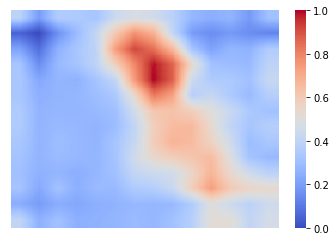

In [23]:
sns.heatmap(heatmap, xticklabels=False, yticklabels=False, cmap="coolwarm")
plt.show();

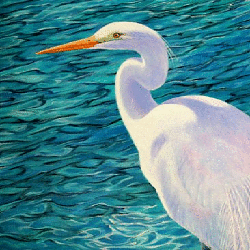

In [24]:
Image.open(img_path).resize((250,250))

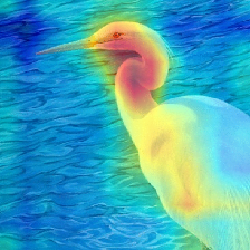

In [25]:
# GradCAM を重ねることで、画像上で可視化。
Image.open(output_path).resize((250,250))